# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Цель

Предсказание рыночной стоимости автомобиля.

## Задачи

1. Построение модели на основе анализа исторических данных: технические характеристики, комплектации и цены автомобилей.

2. Для оценки качества моделей применять метрику RMSE. Значение метрики RMSE должно быть меньше 2500.

3. Контролировать время обучения и предсказания модели (не более минуты?)

## Описание данных

### Признаки

DateCrawled — дата скачивания анкеты из базы

VehicleType — тип автомобильного кузова

RegistrationYear — год регистрации автомобиля

Gearbox — тип коробки передач

Power — мощность (л. с.)

Model — модель автомобиля

Kilometer — пробег (км)

RegistrationMonth — месяц регистрации автомобиля

FuelType — тип топлива

Brand — марка автомобиля

NotRepaired — была машина в ремонте или нет

DateCreated — дата создания анкеты

NumberOfPictures — количество фотографий автомобиля

PostalCode — почтовый индекс владельца анкеты (пользователя)

LastSeen — дата последней активности пользователя

### Целевой признак

Price — цена (евро)

### План работы

Сравним значение метрик RMSE у предсказаний моделей линейной регрессии, дерева решений, случайного леса, градиентного бустинга (LightGBM).

## Подготовка данных

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from random import randint
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
RANDOM_STATE = 12345
RMSE_LIMIT = 2500

In [3]:
df = pd.read_csv('datasets/autos.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df_length = df.shape[0]
df_length

354369

In [5]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
df = df.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354369 non-null  int64 
 1   VehicleType        316879 non-null  object
 2   RegistrationYear   354369 non-null  int64 
 3   Gearbox            334536 non-null  object
 4   Power              354369 non-null  int64 
 5   Model              334664 non-null  object
 6   Kilometer          354369 non-null  int64 
 7   RegistrationMonth  354369 non-null  int64 
 8   FuelType           321474 non-null  object
 9   Brand              354369 non-null  object
 10  NotRepaired        283215 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


In [7]:
df.isna().sum()

Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
dtype: int64

In [8]:
df = df.fillna('other')

In [9]:
df = df.rename(columns={
    'Price': 'price',
    'VehicleType': 'vehicle_type',
    'Gearbox': 'gearbox',
    'Power': 'power',
    'Model': 'model',
    'Kilometer': 'kilometer',
    'FuelType': 'fuel_type',
    'Brand': 'brand',
    'NotRepaired': 'not_repaired',
    'RegistrationYear': 'registration_year',
    'RegistrationMonth': 'registration_month'
})
df.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'not_repaired'],
      dtype='object')

In [10]:
for col in df.columns:
    print(f'{col}: {df[col].value_counts()} \n \n')

price: 0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: price, Length: 3731, dtype: int64 
 

vehicle_type: sedan          91457
small          79831
wagon          65166
other          40778
bus            28775
convertible    20203
coupe          16163
suv            11996
Name: vehicle_type, dtype: int64 
 

registration_year: 2000    24490
1999    22728
2005    22109
2001    20124
2006    19900
        ...  
4100        1
1200        1
5300        1
8888        1
2290        1
Name: registration_year, Length: 151, dtype: int64 
 

gearbox: manual    268251
auto       66285
other      19833
Name: gearbox, dtype: int64 
 

power: 0        40225
75       24023
60       15897
150      14590
101      13298
         ...  
323          1
3454         1
1056         1
13636        1
1158         1
Name: power, Length: 712, dtype: int64 
 

model: other                 4

In [11]:
# Удалим данные с аномальной ценой
df = df.query('price != 0')
df['price'].value_counts()

500      5670
1500     5394
1000     4649
1200     4594
2500     4438
         ... 
5240        1
13180       1
10879       1
2683        1
8188        1
Name: price, Length: 3730, dtype: int64

In [12]:
# Удалим данные с аномальной мощностью
df = df.query('power != 0 and power <= 1600')
df['power'].value_counts()

75      23319
60      15465
150     14170
101     12960
140     12712
        ...  
297         1
700         1
808         1
1115        1
903         1
Name: power, Length: 563, dtype: int64

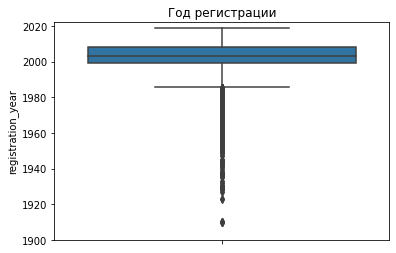

In [13]:
ax = sns.boxplot(data=df, y='registration_year')
ax.set_title('Год регистрации')
ax.set_ylim([1900, 2022])
plt.show()

In [14]:
df.query('registration_year < 1986')['registration_year'].value_counts()

1985    477
1983    345
1984    331
1982    267
1980    267
       ... 
1928      1
1931      1
1927      1
1234      1
1948      1
Name: registration_year, Length: 64, dtype: int64

In [15]:
# Удалим данные с аномальными и/или очень старыми значениями года регистрации
df = df.query('registration_year > 1985 and registration_year <= 2022')
df['registration_year'].value_counts()

1999    19601
2005    18930
2000    18812
2006    18581
2003    17957
2001    17882
2004    17822
2002    17235
2007    16088
1998    15220
2008    14526
2009    13837
1997    12413
2010    10347
2011     9565
1996     9163
2017     7405
1995     7274
2012     6923
2016     6385
1994     4116
2013     3989
1993     2902
2018     2873
1992     2567
2014     2400
1991     2321
1990     1869
1989     1086
2015     1069
1988      796
1987      540
1986      414
2019       10
Name: registration_year, dtype: int64

In [16]:
print(f'Удалено данных: {1 - df.shape[0] / df_length:.0%}')

Удалено данных: 15%


In [17]:
df.head(20)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
1,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,other
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no
8,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,other
9,999,small,1998,manual,101,golf,150000,0,other,volkswagen,other
10,2000,sedan,2004,manual,105,3_reihe,150000,12,petrol,mazda,no
11,2799,wagon,2005,manual,140,passat,150000,12,gasoline,volkswagen,yes


1. Переименовали колонки.

2. Удалили колонки, не несущие смысла для бизнес-задачи.

3. Удалили пропуски в данных.

4. Удалили данные с ценой 0 как аномалии.

5. Удалили выбросы и аномалии в году регистрации автомобиля.

<div class="alert alert-block alert-info">
Присутствуют нулевые значения в признаке price. Цена не может быть нулевой, к тому же это целевой признак. Самое интересное, что на нескольких сайтах по продаже подержанных автомобилей в Германии (страну можно определить по почтовым индексам, большинство из них из Германии) показало, что цены, действительно, начинаются с 0 и 1 евро, но это единичные объявления. Не понятно, то ли это ошибка при заполнении формы, то ли машины на металлолом. Но я все-таки склоняюсь к тому, чтобы избавиться от таких данных.
</div>

<div class="alert alert-block alert-info">
Поправлены аномалии:

- Мощность ограничила максимальной и минимальной приемлемыми мощностями;
- Год регистрации;
- Лишние и константные признаки (признак NumberOfPictures константный, так как все значения равны нулю).


</div>

## Обучение моделей

### Подготовка признаков

In [18]:
# Выделяем целевой признак
target = df['price']
features = df.drop(['price'], axis=1)

display('features:', features.head())
display('target:', target.head())

'features:'

,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
1,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes
2,suv,2004,auto,163,grand,125000,8,gasoline,jeep,other
3,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes


'target:'

1    18300
2     9800
3     1500
4     3600
5      650
Name: price, dtype: int64

In [19]:
# Масштабируем численные признаки
numeric = ['power', 'kilometer']

scaler = StandardScaler()
scaler.fit(features[numeric])
features[numeric] = scaler.transform(features[numeric])
features.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
1,coupe,2011,manual,1.167055,other,-0.104043,5,gasoline,audi,yes
2,suv,2004,auto,0.710121,grand,-0.104043,8,gasoline,jeep,other
3,small,2001,manual,-0.779142,golf,0.582695,6,petrol,volkswagen,no
4,small,2008,manual,-0.880683,fabia,-1.065478,7,gasoline,skoda,no
5,sedan,1995,manual,-0.322209,3er,0.582695,10,petrol,bmw,yes


In [20]:
# Кодируем категориальные переменные методом OHE
features_ohe = pd.get_dummies(features, drop_first=True)
features_ohe.head()

,registration_year,power,kilometer,registration_month,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_other,not_repaired_yes
1,2011,1.167055,-0.104043,5,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2004,0.710121,-0.104043,8,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,2001,-0.779142,0.582695,6,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,2008,-0.880683,-1.065478,7,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,1995,-0.322209,0.582695,10,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [21]:
# Кодируем категориальные переменные методом OrdinalEncoder
encoder_ordinal = OrdinalEncoder()
features_ordinal = pd.DataFrame(encoder_ordinal.fit_transform(features), columns=features.columns)
features_ordinal.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
0,2.0,25.0,1.0,189.0,166.0,11.0,5.0,2.0,1.0,2.0
1,6.0,18.0,0.0,162.0,117.0,11.0,8.0,2.0,14.0,1.0
2,5.0,15.0,1.0,74.0,116.0,12.0,6.0,6.0,38.0,0.0
3,5.0,22.0,1.0,68.0,101.0,9.0,7.0,2.0,31.0,0.0
4,4.0,9.0,1.0,101.0,11.0,12.0,10.0,6.0,2.0,2.0


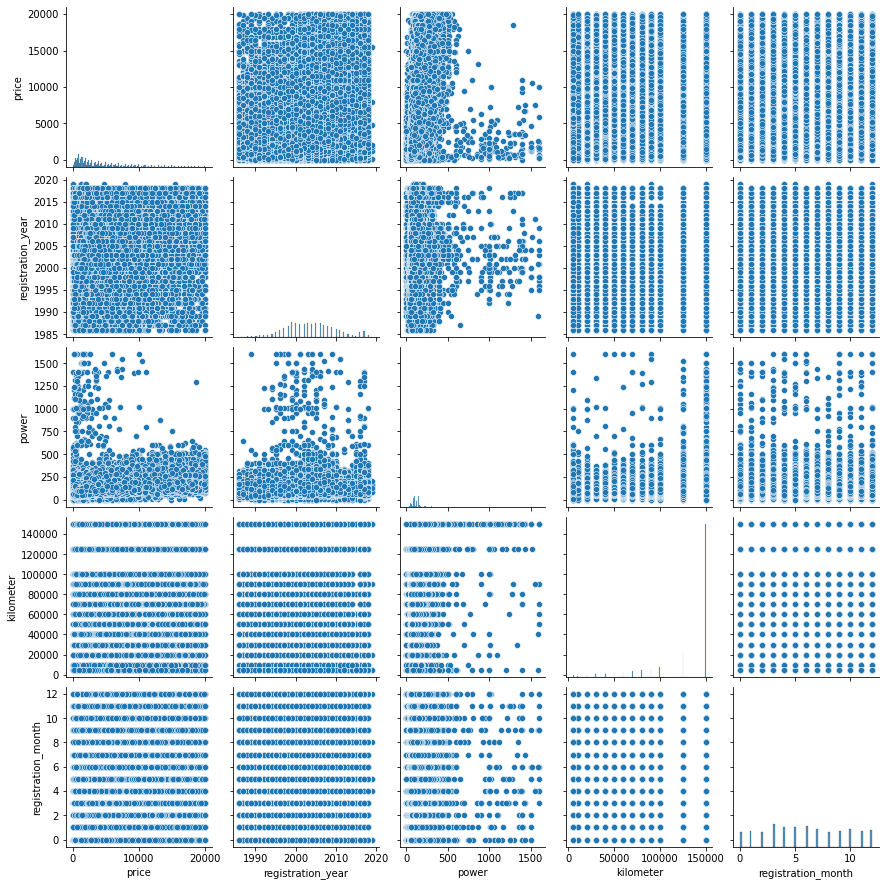

In [22]:
# Проверка признаков на линейные зависимости
sns.pairplot(data=df)

<div class="alert alert-block alert-info">
Сильно зависимых признаков не обнаружено.
</div>

<div class="alert alert-block alert-info">
Для линейных моделей OHE отлично подойдет. Для других стоит использовать порядковое кодирование
</div>

### Выборки OHE

In [23]:
# Делим данные на обучающую и необучающую выборки, закодированные OHE
features_train_ohe, features_untrain_ohe, target_train_ohe, target_untrain_ohe = train_test_split(features_ohe, target, test_size=0.4, random_state=RANDOM_STATE)
display('features_train:', features_train_ohe.head())
display('features_untrain:', features_untrain_ohe.head())
display('target_train:', target_train_ohe.head())
display('target_untrain:', target_untrain_ohe.head())


'features_train:'

,registration_year,power,kilometer,registration_month,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_other,not_repaired_yes
26188,2002,-0.406826,0.582695,7,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
22352,2016,-1.134535,-1.065478,6,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
138480,1998,0.490117,0.582695,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
353223,1999,-0.779142,0.582695,10,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
85033,2018,-1.032994,0.582695,11,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


'features_untrain:'

,registration_year,power,kilometer,registration_month,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_other,not_repaired_yes
27489,1999,-0.322209,0.582695,4,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
69910,2008,0.253188,-1.889564,6,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
204521,1994,-0.525291,0.582695,3,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
201996,2003,-1.134535,0.582695,10,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
30797,2004,0.490117,0.582695,11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


'target_train:'

26188     1699
22352      550
138480    1790
353223    1400
85033     2800
Name: price, dtype: int64

'target_untrain:'

27489      1500
69910     10860
204521      800
201996     1650
30797      4500
Name: price, dtype: int64

In [24]:
# Делим данные на валидационную и тестовую выборки, закодированные OHE
features_valid_ohe, features_test_ohe, target_valid_ohe, target_test_ohe = train_test_split(features_untrain_ohe, target_untrain_ohe, test_size=0.5, random_state=RANDOM_STATE)
display('features_valid', features_valid_ohe.head())
display('features_test', features_test_ohe.head())
display('target_valid', target_valid_ohe.head())
display('target_test', target_test_ohe.head())


'features_valid'

,registration_year,power,kilometer,registration_month,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_other,not_repaired_yes
310413,2006,-0.017587,0.582695,11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44725,1997,-1.032994,0.582695,4,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
182630,1997,0.490117,0.582695,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
279152,2006,-0.271439,0.582695,12,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
240660,2000,-0.339133,0.582695,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


'features_test'

,registration_year,power,kilometer,registration_month,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_other,not_repaired_yes
83988,2005,-0.085281,0.582695,8,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
236388,2007,-0.203745,-1.065478,9,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
43870,2000,0.168571,0.582695,7,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
159045,1997,0.490117,0.582695,11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
182496,1997,0.828586,0.582695,9,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


'target_valid'

310413    6899
44725      350
182630    1000
279152    5850
240660    1800
Name: price, dtype: int64

'target_test'

83988     3800
236388    4999
43870      999
159045    2150
182496    1200
Name: price, dtype: int64

### Выборки OrdinalEncoder

In [25]:
# Делим данные на обучающую и необучающую выборки, закодированные OrdinalEncoder
features_train_ordinal, features_untrain_ordinal, target_train_ordinal, target_untrain_ordinal = train_test_split(features_ordinal, target, test_size=0.4, random_state=RANDOM_STATE)
display('features_train:', features_train_ordinal.head())
display('features_untrain:', features_untrain_ordinal.head())
display('target_train:', target_train_ordinal.head())
display('target_untrain:', target_untrain_ordinal.head())


'features_train:'

,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
22272,7.0,16.0,1.0,96.0,166.0,12.0,7.0,6.0,35.0,0.0
19023,3.0,30.0,1.0,53.0,116.0,9.0,6.0,6.0,38.0,1.0
118347,7.0,12.0,1.0,149.0,11.0,12.0,3.0,6.0,2.0,0.0
301939,5.0,13.0,1.0,74.0,120.0,12.0,10.0,6.0,30.0,0.0
72541,3.0,32.0,1.0,59.0,166.0,12.0,11.0,5.0,31.0,0.0


'features_untrain:'

,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
23357,4.0,13.0,1.0,101.0,33.0,12.0,4.0,6.0,20.0,1.0
59602,4.0,22.0,0.0,135.0,33.0,6.0,6.0,6.0,20.0,0.0
174779,7.0,8.0,1.0,89.0,170.0,12.0,3.0,6.0,38.0,1.0
172602,5.0,17.0,1.0,53.0,101.0,12.0,10.0,6.0,31.0,0.0
26160,7.0,18.0,1.0,149.0,59.0,12.0,11.0,2.0,20.0,0.0


'target_train:'

26188     1699
22352      550
138480    1790
353223    1400
85033     2800
Name: price, dtype: int64

'target_untrain:'

27489      1500
69910     10860
204521      800
201996     1650
30797      4500
Name: price, dtype: int64

In [26]:
# Делим данные на валидационную и тестовую выборки, закодированные OrdinalEncoder
features_valid_ordinal, features_test_ordinal, target_valid_ordinal, target_test_ordinal = train_test_split(features_untrain_ordinal, target_untrain_ordinal, test_size=0.5, random_state=RANDOM_STATE)
display('features_valid', features_valid_ordinal.head())
display('features_test', features_test_ordinal.head())
display('target_valid', target_valid_ordinal.head())
display('target_test', target_test_ordinal.head())


'features_valid'

,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
265370,0.0,20.0,1.0,119.0,93.0,12.0,11.0,2.0,9.0,0.0
38053,5.0,11.0,1.0,59.0,166.0,12.0,4.0,3.0,38.0,0.0
156100,4.0,11.0,1.0,149.0,29.0,12.0,0.0,5.0,1.0,2.0
238749,0.0,20.0,1.0,104.0,220.0,12.0,12.0,2.0,38.0,0.0
205667,7.0,14.0,1.0,100.0,232.0,12.0,6.0,6.0,24.0,0.0


'features_test'

,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
71645,0.0,19.0,1.0,115.0,112.0,12.0,8.0,2.0,10.0,0.0
202001,4.0,21.0,1.0,108.0,69.0,9.0,9.0,6.0,15.0,0.0
37314,4.0,14.0,1.0,130.0,154.0,12.0,7.0,6.0,10.0,0.0
135918,7.0,11.0,1.0,149.0,29.0,12.0,11.0,6.0,1.0,0.0
155986,2.0,11.0,0.0,169.0,11.0,12.0,9.0,6.0,2.0,0.0


'target_valid'

310413    6899
44725      350
182630    1000
279152    5850
240660    1800
Name: price, dtype: int64

'target_test'

83988     3800
236388    4999
43870      999
159045    2150
182496    1200
Name: price, dtype: int64

1. Выделили целевой признак.
2. Закодировали категориальные признаки с удалением первого столбца для избежания дамми-ловушки.
3. Масштабировали численные признаки.
3. Разбили данные на обучающую, валидационную и тестовую выборки.

### Обучение моделей

In [27]:
# Линейная регрессия
model_linear = LinearRegression()
model_linear.fit(features_train_ohe, target_train_ohe)
predictions_linear = model_linear.predict(features_valid_ohe)

rmse = mean_squared_error(target_valid_ohe, predictions_linear) ** 0.5
rmse

2450.877921010593

In [28]:
# Решающее дерево
best_model_tree = None
best_rmse_tree = 0
best_depth_tree = 0

for depth in range(1, 10):
    model_tree = DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth=depth)
    model_tree.fit(features_train_ordinal, target_train_ordinal)
    predictions_tree = model_tree.predict(features_valid_ordinal)
    
    rmse_tree = mean_squared_error(target_valid_ordinal, predictions_tree) ** 0.5

    if (rmse_tree > best_rmse_tree) and (rmse_tree < RMSE_LIMIT):
        best_model_tree = model_tree
        best_rmse_tree = rmse_tree
        best_depth_tree = depth
        
print("RMSE наилучшей модели 'Дерево решений' на валидационной выборке:", best_rmse_tree, "Глубина дерева:", best_depth_tree)

RMSE наилучшей модели 'Дерево решений' на валидационной выборке: 2387.2896448387723 Глубина дерева: 5


<div class="alert alert-block alert-info">
Для моделей основанных на деревьях использовано порядковое кодирование (OrdinalEncoder). Это должно ускорить их работу.
</div>

In [29]:
# Случайный лес
model_forest = RandomForestRegressor()
params = {
    'max_depth': [randint(1, 100)],
    'n_estimators': [randint(1, 100)],
    'random_state': [RANDOM_STATE],
}

grid = GridSearchCV(model_forest, params, scoring='neg_root_mean_squared_error', verbose=3)
grid.fit(features_train_ordinal, target_train_ordinal)
print(grid.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=49, n_estimators=64, random_state=12345; total time=  25.5s
[CV 2/5] END max_depth=49, n_estimators=64, random_state=12345; total time=  25.9s
[CV 3/5] END max_depth=49, n_estimators=64, random_state=12345; total time=  26.1s
[CV 4/5] END max_depth=49, n_estimators=64, random_state=12345; total time=  26.2s
[CV 5/5] END max_depth=49, n_estimators=64, random_state=12345; total time=  26.1s
{'max_depth': 49, 'n_estimators': 64, 'random_state': 12345}


In [30]:
def search_forest(depth, est):
    model_forest = RandomForestRegressor(max_depth=depth, n_estimators=est, random_state=RANDOM_STATE)
    model_forest.fit(features_train_ordinal, target_train_ordinal)
    predictions_forest = model_forest.predict(features_valid_ordinal)

    rmse = mean_squared_error(target_valid_ordinal, predictions_forest) ** 0.5

    print("RMSE наилучшей модели 'Случайный лес'", rmse)

In [31]:
search_forest(94, 14)

RMSE наилучшей модели 'Случайный лес' 1606.662089416546


In [32]:
# LightGBM
best_model_lgbm = None
best_rmse_lgbm = 0
best_est_lgbm = 0

trees = [10, 50, 100]
for n in trees:
    model_lgbm = LGBMRegressor(n_estimators=n, random_state=RANDOM_STATE)
    model_lgbm.fit(features_train_ordinal, target_train_ordinal)
    predictions_lgbm = model_lgbm.predict(features_valid_ordinal)

    rmse_lgbm = mean_squared_error(target_valid_ordinal, predictions_lgbm) ** 0.5

    if (rmse_lgbm > best_rmse_lgbm) and (rmse_lgbm < RMSE_LIMIT):
        best_model_lgbm = model_lgbm
        best_rmse_lgbm = rmse_lgbm
        best_est_lgbm = n
        
print("RMSE наилучшей модели 'LGBMRegressor' на валидационной выборке:", best_rmse_lgbm, "Кол-во деревьев решений:", best_est_lgbm)


RMSE наилучшей модели 'LGBMRegressor' на валидационной выборке: 1750.6214337279773 Кол-во деревьев решений: 50


<div class="alert alert-block alert-info">
Лучшей моделью оказалась Линейная регрессия (RMSE 2450,8).
    </div>

<div class="alert alert-block alert-info">
Гридсерч перебирает все комбинации параметров. Здесь можно выводить метрики после каждой валидации с помощью verbose. И остановить GridSearchCV (Kernel -> Interrupt), если надо.
</div>

## Анализ моделей

In [36]:
%%time
model_best = LGBMRegressor(n_estimators=50, random_state=RANDOM_STATE)
model_best.fit(features_train_ohe, target_train_ohe)

CPU times: user 3.91 s, sys: 266 ms, total: 4.18 s
Wall time: 4.15 s


LGBMRegressor(n_estimators=50, random_state=12345)

In [37]:
%%time
predictions_best = model_best.predict(features_test_ohe)

CPU times: user 379 ms, sys: 92.6 ms, total: 472 ms
Wall time: 402 ms


In [38]:
rmse = mean_squared_error(target_test_ohe, predictions_best) ** 0.5
print("RMSE лучшей модели на тестовой выборке:", rmse)

RMSE лучшей модели на тестовой выборке: 1753.577782337517


<div class="alert alert-block alert-info">
    
При обучении моделей были взяты исторические данные по продаже автомобилей, впервые зарегистрированных за период с 1986 по 2022 (при подготовке данных исключены аномалии и выбросы даты регистрации автомобилей).
    
Было проанализировано качество нескольких моделей обучения - линейная регрессия, решающее дерево, случайный лес и градиентный бустинг (от библиотеки LightGBM). В качестве метрики выбран RMSE.

Модель линейной регресии показала лучшее качество предсказания как на обучающей, так и тестовой выборках (RMSE 2450,8), а также высокие скорость обучения и время предсказания. 

Рекомендуем заказчику модель линейной регрессии.
    </div>

# <font color='orange'>Рекомендации 🔥</font>
* Доступное объяснение про работу градиентного бустинга https://www.youtube.com/watch?v=ZNJ3lKyI-EY&t=995s
* После просмотра видео можешь почитать статью про ансамбли и бустинги https://habr.com/ru/company/ods/blog/645887/
* Подбор гиперпараметров для CatBoost https://translated.turbopages.org/proxy_u/en-ru.ru.35f776b3-62cd57e2-136cbedd-74722d776562/https/www.projectpro.io/recipes/find-optimal-parameters-for-catboost-using-gridsearchcv-for-classification
* Подбор гиперпараметров для LightGBM https://programmersought.com/article/40776531516/
* Разумные способы кодирования категориальных данных для машинного обучения https://machinelearningmastery.ru/smarter-ways-to-encode-categorical-data-for-machine-learning-part-1-of-3-6dca2f71b159/
* Статья про "непонятную" метрику ROC-AUC https://dyakonov.org/2017/07/28/auc-roc-площадь-под-кривой-ошибок/
* Хочешь подтянуть математику для DS?) https://academy.stepik.org/math-for-data-science
* Результы обучения моделей можно визуализировать 😎 https://www.datatechnotes.com/2019/08/elasticnet-regression-example-in-python.html
* В нашем деле нужно быть всегда в курсе всех новинок, новостей и тд, вот тут публикуют новости в области DS: https://www.infoq.com/data-analysis/news/